<a href="https://colab.research.google.com/github/cezgru/AI_for_Industry_4.0/blob/master/AI_for_Industry_4_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AI for Industry 4.0 Recruitment Task**
This project is an solution to the recruitment task for the Codeschool x SDA Data Science Upskill course application, given here https://drive.google.com/file/d/1WGQ8H6_l07yqe1JIQC1hQ6RWutZqqJbn/view


## **Problem understanding and client needs**
Our objective is to create a prediction model, that will allow our client to extrapolate measurements from a single session. Specifically, we are provided data test measurements for fibre optic sensors, gathered in three reference substances. These will then be used for verification of our sensor's characteristics. Our model will be use measurements conducted in air in order to predict measurements from water and izopropanol. This will save our client a lot of costs and manpower associated with doing measurements in these substances.

## **Background research**
In order to understand the data we will be working with, as well as a deeper understanding of our objective, we need to delve into the world of fibre optics.

In our research, we primarily utilized the *Reference Guide* provided by [The Fiber Optic Association](https://www.thefoa.org/) .

The chapter of most use to us is, as one would expect, Fiber Optic Testing, which contains valueable information on the process that we are trying to predict. Given the rather limited explanation provided in our task, the most useful topics pertain to the meaning and use of the units provided in our dataset.

## **Understanding provided data**
**Note:** The recruitment task says our data was gathered from ten different sensors, which makes sense with regards to some of the values and will be our assumption moving forward. However, the names of the files themselves contain the word *sesion*, which could be a misspelling of the word *session*. This could imply the data was gathered from a single sensor over multiple tests. As mentioned, we shall be operating under the assumption that the first interpretation is the valid one.

[Reference Guide's topic on testing measurement units.](https://www.thefoa.org/tech/ref/testing/test/dB.html)


The data given to us contains wavelengths and amplitudes gathered from ten different sensors. The image provided in the recruitment task clarifies that our amplitude is given by dB, which is a unit of measurement for optical loss. The exact formula for it is provided via the aforementioned reference guide:

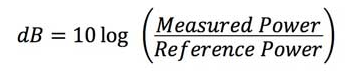

As such dB is a logarithmic scale that represent how strong a measured signal is compared to it's referenced power.

The other axis given in our dataset is the wavelength of the measured radiation which specifically falls in the infrared spectrum. Moreover, the values given to us suggest we are dealing with *Singlemode Fibres*. Armed with this knowledge we can begin examining the provided data.

#1. **Exploratory Data Analysis**
We will now import and analyze the data provided to us by the client. We first read in our data, check if it requires any sanitization and perform it if needed.

In [167]:
# Necessary imports

from google.colab import drive
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from functools import reduce
from sklearn.metrics import mean_squared_error
from math import sqrt
import pickle

In [168]:
# Since we are required to complete this project in Google Colab, we will use it's integration with Google Drive to store our data
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [169]:
def df_list_from_find(text, columns=[]):
  '''
  Creates a list of dataframes from files containing a given string.
  
  The function scans the working directory and it's subdirectories via the
  OS's 'find' function for the '-name' argument. It then pipes the results 
  into a temporary file which will contain all the paths. A pandas DataFrame
  is constructed via read_csv for each file found at the contained addresses, 
  which then gets added to a list returned by this function.

  Parameters:
      text (string): argument of the OS's 'find -name' function.
      columns (list string): names of the columns of created dataframes 
  
  Returns:
      list pd.DataFrame: list containing dataframes created from each found file
  '''

  df_list = []
  os.system(f"find . -name '{text}' > tmp.txt")
  with open('tmp.txt') as file:
    for line in file:
        df_list.append(pd.read_csv(line.rstrip(), names=columns))
  os.system('rm tmp.txt')
  return df_list

In [170]:
# Read in data
sensors_air = df_list_from_find('*air.txt', ['wavelength','amplitude'])
sensors_izopropanol = df_list_from_find('*izopropanol.txt', ['wavelength','amplitude'])
sensors_water = df_list_from_find('*water.txt', ['wavelength','amplitude'])

### Sanitation

In [171]:
# Check for missing values and inconsistencies between input data. The shape is 
# compared to 3001x2, a value manually taken from one of the input files.
print('Sensors Air:')
for i, s in enumerate(sensors_air):
  if (s.shape != (3001,2)):
    print(f'Different shape in index: {i}')
  if (s['wavelength'].isnull().any() > 0 or s['amplitude'].isnull().any()):
    print(f'Null values found in index: {i}')
print('Done')
  
print('Sensors Izopropanol:')
for i, s in enumerate(sensors_izopropanol):
  if (s.shape != (3001,2)):
    print(f'Different shape in index: {i}')
  if (s['wavelength'].isnull().any() > 0 or s['amplitude'].isnull().any()):
    print(f'Null values found in index: {i}')
print('Done')

print('Sensors Water:')
for i, s in enumerate(sensors_water):
  if (s.shape != (3001,2)):
    print(f'Different shape in index: {i}')
  if (s['wavelength'].isnull().any() > 0 or s['amplitude'].isnull().any()):
    print(f'Null values found in index: {i}')
print('Done')

Sensors Air:
Done
Sensors Izopropanol:
Done
Sensors Water:
Done


In [172]:
sensors_air[0]

,wavelength,amplitude
0,0.000001,7.8831
1,0.000001,8.0971
2,0.000001,7.9478
3,0.000001,7.9979
4,0.000001,7.9220
...,...,...
2996,0.000002,2.3074
2997,0.000002,2.3935
2998,0.000002,2.2550
2999,0.000002,2.4935


Our data is void of any issues, thus no sanitization is required. As we can see, it contains wavelengths and amplitudes. Whilst are amplitudes are provided in our preffered unit of measurement dB, the wavelengths are given to us in metres in the form of scientific notation. The usual unit used for fibre optics is the nanometre (nm). Converting from one to the other is as simple as multiplying the amount of metres by 10^9. We shall do this for our convenience as it doesnt fundamentally change the meaning of our data. 

In [173]:
for s in sensors_air:
  s['wavelength'] = s['wavelength'].multiply(10**9)
for s in sensors_izopropanol:
  s['wavelength'] = s['wavelength'].multiply(10**9)
for s in sensors_water:
  s['wavelength'] = s['wavelength'].multiply(10**9)

With our units of measurement being in the desired format, we can now visualize the characteristics of each of our sensors, and start looking for any similarities or discrepancies between them. Electromagnetic waves are continuous(sort of, let's not get into photons and quantum mechanics) thus we want our data to be represented continuously as well. Hence line plots.

### Initial plots, comparing datasets

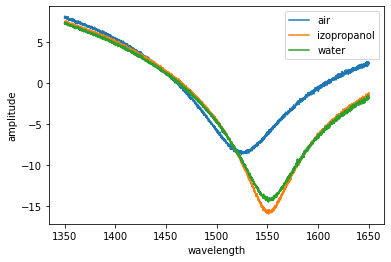

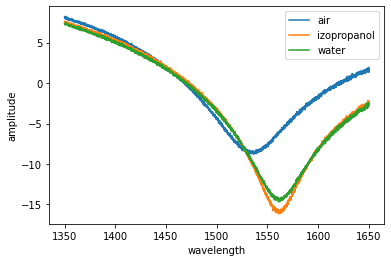

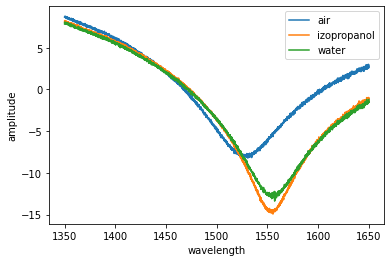

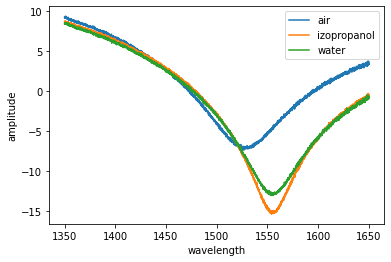

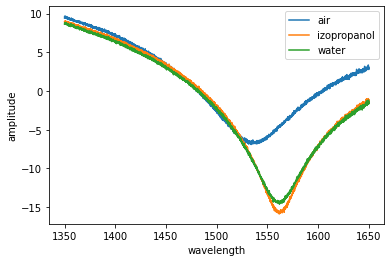

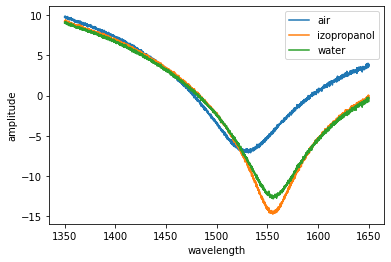

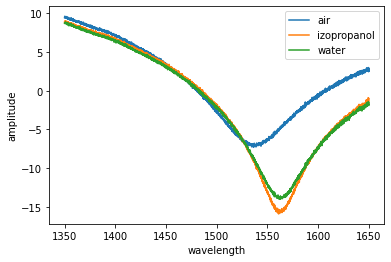

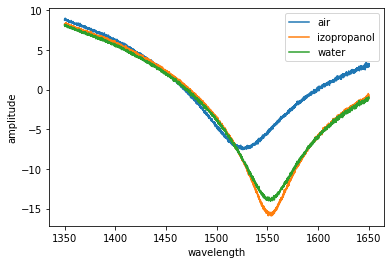

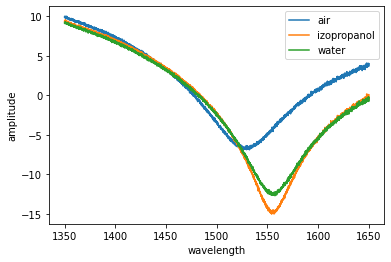

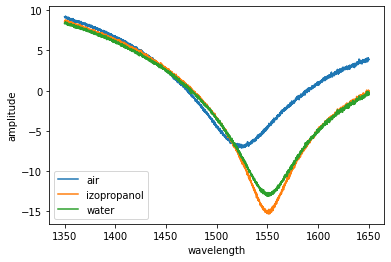

In [174]:
for i in range(10):
  sns.lineplot(data=sensors_air[i], x='wavelength', y='amplitude', palette = 'blue', label = 'air')
  sns.lineplot(data=sensors_izopropanol[i], x='wavelength', y='amplitude', palette = 'orange', label = 'izopropanol')
  sns.lineplot(data=sensors_water[i], x='wavelength', y='amplitude', palette = 'green', label = 'water')
  plt.show()

### Initial observations

As expected measurements from our sensors are similar enough, as one would hope given what they represent. 
* The measurements for water and izopropanol are very similar, which makes sense given they are both liquids.
* Izopropanol has a more pronounced extremum than water
* The local minimum is even smoother for air and occurs earlier in the spectrum
* The increase past the extremum seems to run roughly parralell for all 3 substances
* The inflection point for air usually occurs earlier than for the other two

Given the obvious similarities between all sensors, we will only analyze a single one moving forward. We will mostly focus our input data, which is the measurement conducted in air.

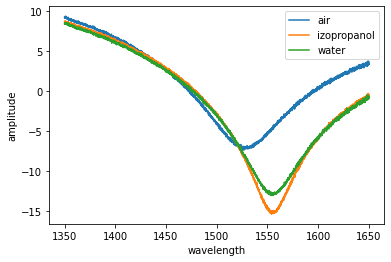

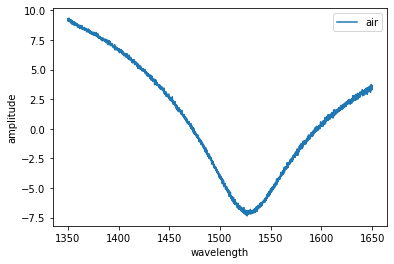

In [175]:
# Index of dataframe used for further analysis, 3 seemed like a decent choice
idx = 3
sns.lineplot(data=sensors_air[idx], x='wavelength', y='amplitude', palette = 'blue', label = 'air')
sns.lineplot(data=sensors_izopropanol[idx], x='wavelength', y='amplitude', palette = 'orange', label = 'izopropanol')
sns.lineplot(data=sensors_water[idx], x='wavelength', y='amplitude', palette = 'green', label = 'water')
plt.show()
sns.lineplot(data=sensors_air[idx], x='wavelength', y='amplitude', palette = 'blue', label = 'air')
plt.show()

In [176]:
sensors_air[idx]

,wavelength,amplitude
0,1350.0,9.2124
1,1350.1,9.2734
2,1350.2,9.1703
3,1350.3,9.2478
4,1350.4,9.0771
...,...,...
2996,1649.6,3.2784
2997,1649.7,3.4213
2998,1649.8,3.3112
2999,1649.9,3.4500


In [177]:
sensors_air[idx].describe

<bound method NDFrame.describe of       wavelength  amplitude
0         1350.0     9.2124
1         1350.1     9.2734
2         1350.2     9.1703
3         1350.3     9.2478
4         1350.4     9.0771
...          ...        ...
2996      1649.6     3.2784
2997      1649.7     3.4213
2998      1649.8     3.3112
2999      1649.9     3.4500
3000      1650.0     3.6370

[3001 rows x 2 columns]>

### Amplitude density
Let use take a look at how our values are distributed

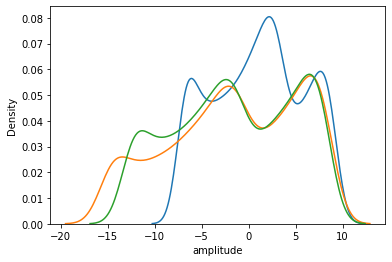

In [178]:
sns.kdeplot(x='amplitude', data=sensors_air[idx], palette = 'blue', label = 'air')
sns.kdeplot(x='amplitude', data=sensors_izopropanol[idx], palette = 'orange', label = 'izopropanol')
sns.kdeplot(x='amplitude', data=sensors_water[idx], palette = 'green', label = 'water')
plt.show()

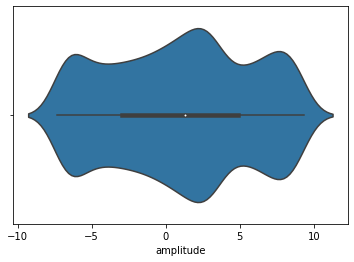

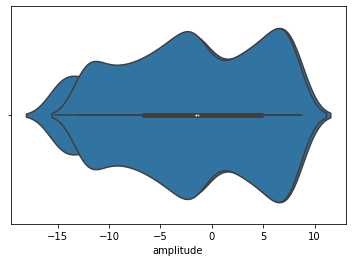

In [179]:
sns.violinplot(x='amplitude', data=sensors_air[idx])
plt.show()
sns.violinplot(x='amplitude', data=sensors_izopropanol[idx])
sns.violinplot(x='amplitude', data=sensors_water[idx])
plt.show()

As expected from plotting the data, the distribution for izopropanol and water is very similar. Air has a similar though somewhat squished structure, with the exception of a local extrema at values slightly over zero, where instead of a minimum it has a maximum. This is likely the biggest hurdle for us to overcome.

In [180]:
print(sensors_air[idx].corrwith(sensors_water[idx]))
print(sensors_air[idx].corrwith(sensors_izopropanol[idx]))
print(sensors_water[idx].corrwith(sensors_izopropanol[idx]))

wavelength    1.000000
amplitude     0.883004
dtype: float64
wavelength    1.000000
amplitude     0.871873
dtype: float64
wavelength    1.000000
amplitude     0.998096
dtype: float64


Correlation is generally high, which means a simpler regression model will likely be sufficient. Izopropanol and water are both our targets, thus their extreme similarity is a non-issue.

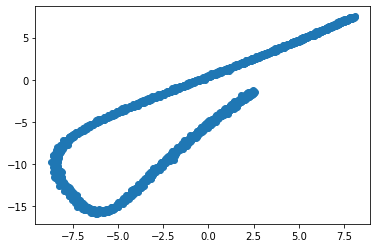

In [181]:
plt.scatter(sensors_air[0]['amplitude'], sensors_izopropanol[0]['amplitude'])

Uhhh... yeah. We could say its roughly linear... sometimes... We'll see how it goes. Not too much more to read into here.

# 2. Data Processing and Feature Engineering

## Smoothing filter

As expected for such data, whilst trend are clearly visibile the data has a tendancy to have a high variance on a local level. Since we know the actual characteristic is continuous, we could try to extrapolate it by trying to remove the noise. After a little trial and error I decided to use LOWESS, or locally weightted estimated scatterplot smoothing. This felt like a natural choice given the everpresent but local noise, and yielded satisfactory results. 

### Reasoning
Whilst using regression before trying to... use regression can feel a little odd, the reasons for removing noise first are twofold:
* Characteristic is continuous so any noise is just that, noise. As such it should be disregarded so as not to impact our model
* We only have a single value as our measurement: amplitude. As such our data is simple function y=f(x). This motivates us to utilise simple function investigation via calculus. This approach does however require strict continuouity, necessitating removal of any local variance

In [182]:
def filter_dataframe(df, fraction):
    return pd.DataFrame(sm.nonparametric.lowess(df.iloc[:,1],df.iloc[:,0], frac = fraction), columns = ['wavelength', 'amplitude'])

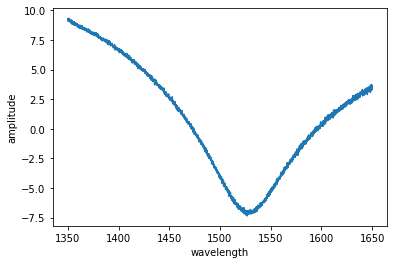

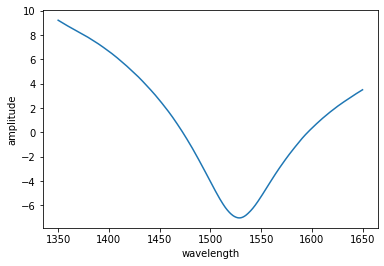

In [183]:
# Apply the LOWESS filter to our dataframe. A frac value of 0.05 yielded satisfactory results without disrupting the data too much
fraction = 0.05
s_a_idx_filtered = filter_dataframe(sensors_air[idx], fraction)
sns.lineplot(data=sensors_air[idx], x='wavelength', y='amplitude')
plt.show()
sns.lineplot(data=s_a_idx_filtered, x='wavelength', y='amplitude')
plt.show()

## Feature Extraction
With that out of the way, we can now start thinking about adding additional features to our data. There is a problem though: we only have a single input vector of data. Wavelength is a glorified index, and we will use it as such. So then what can we even do with our data without a massive degree of correlation? This is where continuouity comes in. We can now add a swath of mathematical properties of our function. This could include, though are not limited to:
* Derivatives
* Integrals
* Asymptotes

Now, the transformation we are trying to apply is:

T(air(wavelength)) = izopropanol(wavelength)

Given the similarity between both graphs, we probably shouldn't look to add a large amount of features. As such we will limit ourselves to the derivative for the time being. This should help us with identifying locations of our extremum, the largest discrepancy between the two.

In [184]:
# The function adds the derivative of the amplitude in regards to the wavelength.
# We use the direct definition of the derivative, lim h->0 f(x+h) - f(x)  /  h
# We can get h as close to zero as possible by using consecutive points from our dataset
def add_derivatives(df):
  derivative = []
  for i in range(len(df['wavelength'])-1):
    derivative.append(((df['amplitude'][i+1]-df['amplitude'][i])/((df['wavelength'][i+1]-df['wavelength'][i]))))
  # We repeat the last derivative since we don't have a further datapoint to go off of  
  derivative.append(derivative[-1])
  df['derivative'] = derivative
  return df

With both changes coded in, we apply the smoothing filter to all of our dataframes, as well as add our derivative feature to our input data (air).
We also set wavelength to be the index in preperation for modeling.

In [185]:
s_a = [add_derivatives(filter_dataframe(df, fraction)).set_index('wavelength') for df in sensors_air]
s_i = [filter_dataframe(df, fraction).set_index('wavelength') for df in sensors_izopropanol]
s_w = [filter_dataframe(df, fraction).set_index('wavelength') for df in sensors_water]
s_a[0]

,amplitude,derivative
wavelength,,
1350.0,7.995273,-0.050080
1350.1,7.990265,-0.050073
1350.2,7.985258,-0.050066
1350.3,7.980251,-0.050059
1350.4,7.975245,-0.050052
...,...,...
1649.6,2.359792,0.047096
1649.7,2.364501,0.047135
1649.8,2.369215,0.047174


# 3. Modeling
To avoid overfitting our model, we will perform Leave One Out Cross Validation.
Since our data is gathered from 10 different sensors, it's as simple as training on 9 of them and testing on the one left out. Thus we can just iterate over our lists.

We will use the average of the nine models for our modeling, since the data points for each are so similar. Using something like the mean

We will utilise a normalised RMSE score in order to judge the accuracy of the model in our cross validation in order to identify the biggest outliers.

In [186]:
# Returns the averaged dataframe, excluding a single index
def average_dataframe_LOO(df_list, omit_index):
  tmp =  df_list[:omit_index] + df_list[omit_index+1:]
  return reduce(lambda x, y: x.add(y), tmp)/len(tmp)

## Linear Regression

In [187]:
for i in range(len(s_a)):
  X = average_dataframe_LOO(s_a, i)
  y = average_dataframe_LOO(s_i, i)
  model = LinearRegression().fit(X, y)
  X_test = s_a[i]
  y_test = s_i[i]
  y_pred = model.predict(X_test)
  print(f'Normalised RMSE {i}: {sqrt(mean_squared_error(y_test, y_pred))/(y_test["amplitude"].max()-y_test["amplitude"].min())}')

Normalised RMSE 0: 0.03933646177023101
Normalised RMSE 1: 0.037874975997424495
Normalised RMSE 2: 0.04106480975247582
Normalised RMSE 3: 0.03898216210658861
Normalised RMSE 4: 0.03937352964602506
Normalised RMSE 5: 0.03617553169876958
Normalised RMSE 6: 0.03555497893196779
Normalised RMSE 7: 0.037040801706494264
Normalised RMSE 8: 0.03832590172919808
Normalised RMSE 9: 0.03800345255329886


Our RMSE scores are fairly consistent, so not much overfitting seems to have been done. We are safe to train our final linear model on the entire dataset.

In [188]:
X_final = reduce(lambda x, y: x.add(y), s_a)/len(s_a)
y_final_izopropanol = reduce(lambda x, y: x.add(y), s_i)/len(s_i)  
y_final_water = reduce(lambda x, y: x.add(y), s_w)/len(s_w)  
model_izopropanol = LinearRegression().fit(X_final, y_final_izopropanol)
model_water = LinearRegression().fit(X_final, y_final_water)

In [189]:
predict = model_izopropanol.predict(s_a[2])
df = pd.DataFrame(data=s_a[2].index.values, columns=['wavelength'])
df['amplitude'] = predict
# We add our smoothing filter since our output should be a smooth curve
df = filter_dataframe(df, fraction)
df = df.set_index('wavelength')

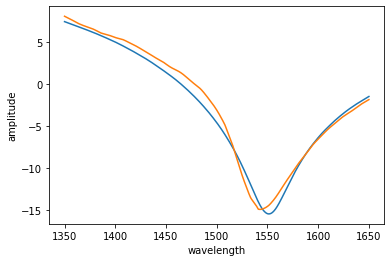

In [190]:
sns.lineplot(data=s_i[0], x='wavelength', y='amplitude')
sns.lineplot(data=df, x='wavelength', y='amplitude')
plt.show()

Our linear model, whilst on the right track, clearly has some issues. Let  us try a polynomial approach instead.

## Polynomial Regression

### Second Degree

In [191]:
for i in range(len(s_a)):
  X = average_dataframe_LOO(s_a, i)
  y = average_dataframe_LOO(s_i, i)
  poly_reg = PolynomialFeatures(degree=2)
  X_poly = poly_reg.fit_transform(X)
  model = LinearRegression().fit(X_poly, y)
  X_test = s_a[i]
  y_test = s_i[i]
  y_pred = model.predict(poly_reg.fit_transform(X_test))
  print(f'Normalised RMSE {i}: {sqrt(mean_squared_error(y_test, y_pred))/(y_test["amplitude"].max()-y_test["amplitude"].min())}')

Normalised RMSE 0: 0.02101776504857064
Normalised RMSE 1: 0.019061849981164572
Normalised RMSE 2: 0.028525935693284234
Normalised RMSE 3: 0.0170025943388763
Normalised RMSE 4: 0.0271431720847858
Normalised RMSE 5: 0.017445250629228908
Normalised RMSE 6: 0.019395072865968012
Normalised RMSE 7: 0.0157940459803628
Normalised RMSE 8: 0.0166636925440349
Normalised RMSE 9: 0.015816528296673953


Much better RMSE scores than our linear model, however we seem to have two outliers at indexes 2 and 4. Before investigating further, let us see if moving up a degree yields better results.

### Third Degree

In [192]:
for i in range(len(s_a)):
  X = average_dataframe_LOO(s_a, i)
  y = average_dataframe_LOO(s_i, i)
  poly_reg = PolynomialFeatures(degree=3)
  X_poly = poly_reg.fit_transform(X)
  model = LinearRegression().fit(X_poly, y)
  X_test = s_a[i]
  y_test = s_i[i]
  y_pred = model.predict(poly_reg.fit_transform(X_test))
  print(f'Normalised RMSE {i}: {sqrt(mean_squared_error(y_test, y_pred))/(y_test["amplitude"].max()-y_test["amplitude"].min())}')

Normalised RMSE 0: 0.017888664589621822
Normalised RMSE 1: 0.017606109356180576
Normalised RMSE 2: 0.027708971005802174
Normalised RMSE 3: 0.009029000120188672
Normalised RMSE 4: 0.027586254409429165
Normalised RMSE 5: 0.01811659527882309
Normalised RMSE 6: 0.017185033149840465
Normalised RMSE 7: 0.010666005167716618
Normalised RMSE 8: 0.010185459778812569
Normalised RMSE 9: 0.012230253111479305


Better RMSE but still issues present at indexes 2 and 4. The scores of those two are very similar to the ones produced by the second degree model. Nevertheless, we will utilise this for our final model for the time being, with clear improvements being possible in the future. A different regression approach may yield better results, as might changing some of our features. Let us proceed with the finalized model.

In [193]:
X_final_poly = poly_reg.fit_transform(reduce(lambda x, y: x.add(y), s_a)/len(s_a))
y_final_izopropanol = reduce(lambda x, y: x.add(y), s_i)/len(s_i) 
y_final_water = reduce(lambda x, y: x.add(y), s_w)/len(s_w)  
model_izopropanol_poly = LinearRegression().fit(X_final_poly, y_final_izopropanol)
model_water_poly = LinearRegression().fit(X_final_poly, y_final_water)


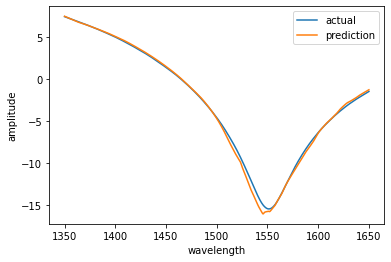

In [194]:
predict = model_izopropanol_poly.predict(poly_reg.fit_transform(s_a[0]))
df = pd.DataFrame(data=s_a[0].index.values, columns=['wavelength'])
df['amplitude'] = predict
df = filter_dataframe(df, fraction)
df = df.set_index('wavelength')

sns.lineplot(data=s_i[0], x='wavelength', y='amplitude', label='actual')
sns.lineplot(data=df, x='wavelength', y='amplitude', label='prediction')

plt.show()

Our model comes rather close, but we seem to be running into some issues around the extremum itself. Let us continue by comparing our model's predictions with one of our larger outliers, index 4.

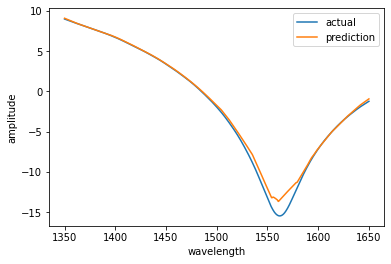

In [195]:
predict = model_izopropanol_poly.predict(poly_reg.fit_transform(s_a[4]))
df = pd.DataFrame(data=s_a[4].index.values, columns=['wavelength'])
df['amplitude'] = predict
df = filter_dataframe(df, fraction)
df = df.set_index('wavelength')

sns.lineplot(data=s_i[4], x='wavelength', y='amplitude', label = 'actual')
sns.lineplot(data=df, x='wavelength', y='amplitude', label = 'prediction')

plt.show()

Clearly our model will need some improvement in the one aforementioned area. Still, it is the one we shall go with for the time being. Time to save the finalized models for izopropanol and water.

In [196]:
pickle.dump(model_izopropanol_poly, open('izopropanol_model.sav','wb'))
pickle.dump(model_water_poly, open('water_model.sav', 'wb'))

#4. Future Improvements

As functional as the models are for most wavelengths, the issue of the local minimum remains. Some things to change or optimize are:
* The impact of the derivative - values close to zero, which correspond to the minimum, could be the problem point for us
* Additional features - there are many properties of our function that could be added, their impact should be worth testing
* Smoothing filters - different types, parameters and use cases for filters should be considered
* Using average values - the average could account for issues with outliers, mostly due to y-axis offsets between sensors (consider dropping values altogether, instead relying on derivatives to perserve shape, and integrating with local datapoints to calculate offset? essentially a differential equation based approach)
* Different regression technique - linear and polynomial regression seemed adeqate given the apparent similarities between datapoints, other models should be considered
